In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import re
from textblob import TextBlob

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')

# Load the dataset - Update this path to match your file location
df = pd.read_csv('/Users/ritikabajpai/Desktop/channel_posts.csv', low_memory=False)

# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (36275, 5)

Column names:
['post_id', 'timestamp', 'sender_id', 'text', 'reply_to_msg_id']

First few rows:
   post_id            timestamp      sender_id  \
0    41893  2025-06-17 15:21:11 -1002232221544   
1    41892  2025-06-17 15:14:18 -1002232221544   
2    41890  2025-06-17 15:05:33 -1002232221544   
3    41889  2025-06-17 14:59:27 -1002232221544   
4    41888  2025-06-17 14:37:26 -1002232221544   

                                                text  reply_to_msg_id  
0  #studies✍🏼  Y1S1: CS1101S Programming Methodol...              NaN  
1  #advice🗣️  Is it normal to be jealous of my fr...              NaN  
2  #advice🗣️  Financial Advisors 🗣 or Fast Moving...              NaN  
3  #advice🗣️  Food service 🍕 or event staff 🎟️ ro...              NaN  
4  #random✨  i’m a jisoo stan but no deity in exi...              NaN  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ritikabajpai/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ritikabajpai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# ---- DATA CLEANING FOR SENTIMENT ANALYSIS ----

# Check the text column - it appears to be 'text' from your CSV
text_column = 'text'  # This matches your CSV

# Check for missing values in text column
print(f"\nMissing values in '{text_column}': {df[text_column].isnull().sum()}")
print(f"Empty strings in '{text_column}': {(df[text_column] == '').sum()}")

# Function to clean text for better sentiment analysis
def clean_text_for_sentiment(text):
    if pd.isna(text) or text == '':
        return None
    
    # Convert to string if not already
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove hashtags but keep the text
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove @mentions but keep context
    text = re.sub(r'@\w+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

# Clean the text
df['cleaned_text'] = df[text_column].apply(clean_text_for_sentiment)

# Remove rows where cleaned text is None or very short (less than 3 characters)
df_sentiment = df[df['cleaned_text'].notna() & (df['cleaned_text'].str.len() >= 3)].copy()

print(f"\nRows with valid text for sentiment analysis: {len(df_sentiment)}")


Missing values in 'text': 0
Empty strings in 'text': 0

Rows with valid text for sentiment analysis: 36275


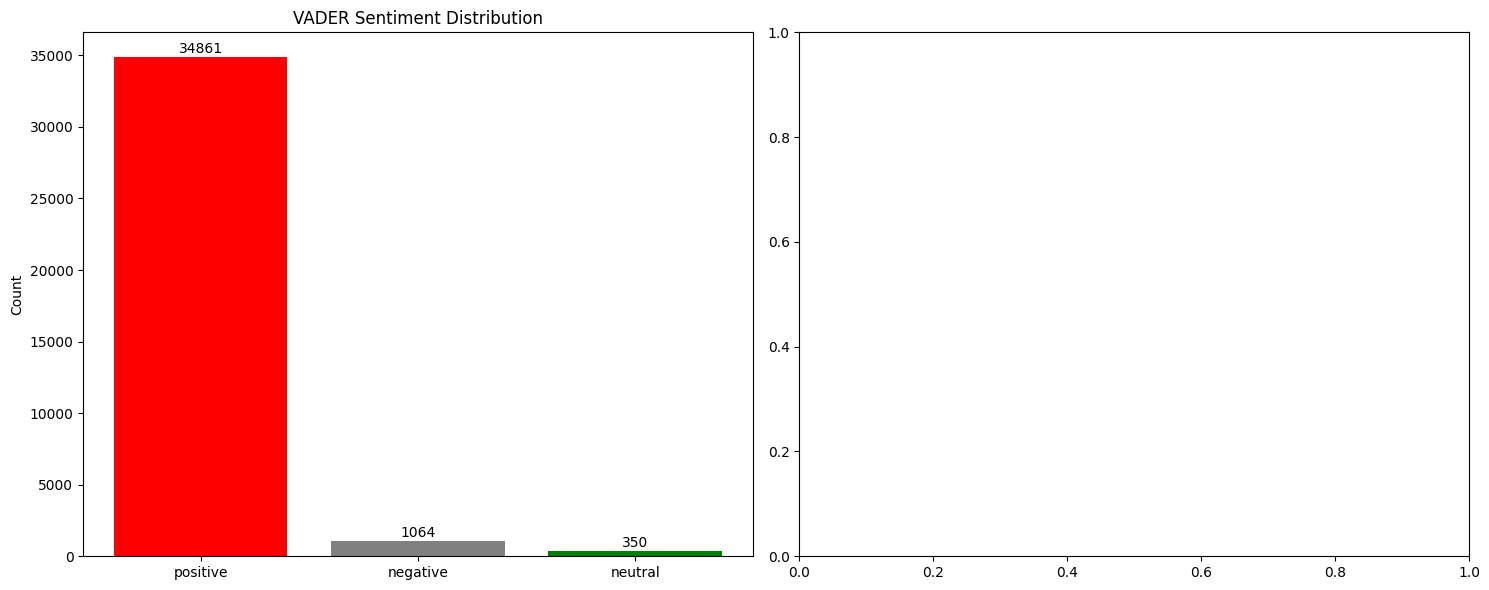

In [16]:
# ---- SENTIMENT ANALYSIS WITH MULTIPLE METHODS ----

# Method 1: VADER Sentiment (good for social media text)
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    if pd.isna(text) or text == '':
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    return sia.polarity_scores(text)

# Apply VADER sentiment
vader_scores = df_sentiment['cleaned_text'].apply(get_vader_sentiment)
df_sentiment['vader_compound'] = [score['compound'] for score in vader_scores]
df_sentiment['vader_positive'] = [score['pos'] for score in vader_scores]
df_sentiment['vader_neutral'] = [score['neu'] for score in vader_scores]
df_sentiment['vader_negative'] = [score['neg'] for score in vader_scores]

# VADER-based classification (more robust thresholds)
def classify_vader_sentiment(compound_score):
    if compound_score >= 0.1:
        return 'positive'
    elif compound_score <= -0.1:
        return 'negative'
    else:
        return 'neutral'

df_sentiment['vader_sentiment'] = df_sentiment['vader_compound'].apply(classify_vader_sentiment)

# 1. Compare sentiment distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# VADER sentiment distribution
vader_counts = df_sentiment['vader_sentiment'].value_counts()
axes[0].bar(vader_counts.index, vader_counts.values, color=['red', 'gray', 'green'])
axes[0].set_title('VADER Sentiment Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(vader_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

DEBUGGING SENTIMENT ANALYSIS

1. EXAMINING RAW TEXT DATA
------------------------------
Total rows: 36275
Text column type: object
Null values in text: 0
Empty strings: 0

Sample raw text (first 5 posts):
1. Length: 1892 chars
   Text: #studies✍🏼  Y1S1: CS1101S Programming Methodology MA1100T Basic Discrete Mathematics (T) MA2001 Linear Algebra I MA2002 Calculus  Y1S2: CS2030S Progra...

2. Length: 208 chars
   Text: #advice🗣️  Is it normal to be jealous of my friend who got into Jp Morgan while I only got into a boutique firm  #A06170082 | SMU Confess Channel |  P...

3. Length: 320 chars
   Text: #advice🗣️  Financial Advisors 🗣 or Fast Moving Consumer Good Resellers 📦 roles are underrated internships, so if you think only big names matter, reme...

4. Length: 291 chars
   Text: #advice🗣️  Food service 🍕 or event staff 🎟️ roles are underrated internships, so if you think only big names matter, remember most people started at t...

5. Length: 238 chars
   Text: #random✨  i’m a jisoo st

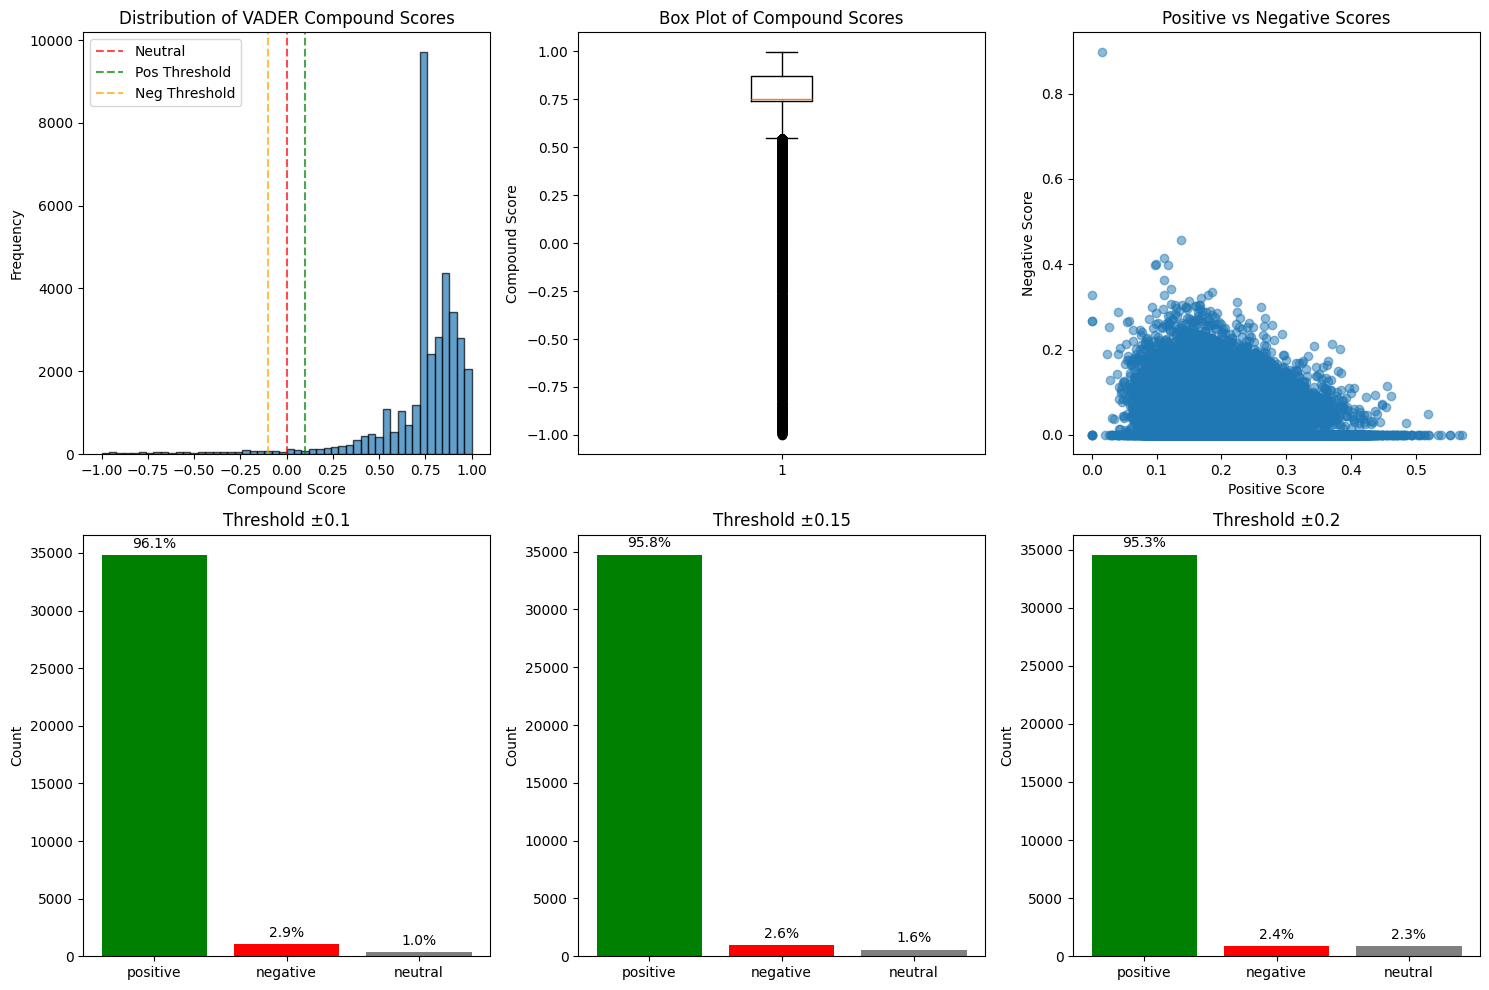


6. EXTREME EXAMPLES FOR VALIDATION
------------------------------
MOST POSITIVE posts:
1. Score: 0.999
   Text: love❤️ OP of both L05220045 and L05230017 This advice probably applies to everyone, regardless if you graduated or not, but the first step to meeting new friends first starts with being a good friend....

2. Score: 0.999
   Text: love❤️ honestly, its all about compromising and equal love girls can expect lovely gestures like handmade bouquets for example, and it does exist — but it should be two sided, where the guy can expect...

3. Score: 0.999
   Text: love❤️ In the depths of my heart, a love so true, But you'll never feel the same, that I knew. I cherish you with every beat, every breath, Yet your love for me remains a silent depth. I dream of a wo...

4. Score: 0.998
   Text: love❤️ My Dearest Brannon Cho, From the moment I heard your name, a current of admiration swept me away, much like the waters you so gracefully navigate. Your story is one of adventure, passion, an

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# Load your data (adjust path as needed)
df = pd.read_csv('/Users/ritikabajpai/Desktop/channel_posts.csv', low_memory=False)

print("=" * 50)
print("DEBUGGING SENTIMENT ANALYSIS")
print("=" * 50)

# Step 1: Examine the raw text data
print("\n1. EXAMINING RAW TEXT DATA")
print("-" * 30)
print(f"Total rows: {len(df)}")
print(f"Text column type: {df['text'].dtype}")
print(f"Null values in text: {df['text'].isnull().sum()}")
print(f"Empty strings: {(df['text'] == '').sum()}")

# Show sample raw text
print("\nSample raw text (first 5 posts):")
for i in range(min(5, len(df))):
    text = str(df['text'].iloc[i])
    print(f"{i+1}. Length: {len(text)} chars")
    print(f"   Text: {text[:150]}{'...' if len(text) > 150 else ''}")
    print()

# Step 2: Check for data quality issues
print("\n2. DATA QUALITY CHECK")
print("-" * 30)

# Check text lengths
text_lengths = df['text'].astype(str).str.len()
print(f"Average text length: {text_lengths.mean():.1f} characters")
print(f"Median text length: {text_lengths.median():.1f} characters")
print(f"Min text length: {text_lengths.min()}")
print(f"Max text length: {text_lengths.max()}")

# Check for very short texts that might skew results
very_short = (text_lengths < 10).sum()
print(f"Posts with less than 10 characters: {very_short} ({very_short/len(df)*100:.1f}%)")

# Check for duplicate or template-like text
print(f"Duplicate texts: {df['text'].duplicated().sum()}")

# Step 3: Manual sentiment check on sample data
print("\n3. MANUAL SENTIMENT CHECK")
print("-" * 30)

sia = SentimentIntensityAnalyzer()

# Get a random sample of posts for manual inspection
np.random.seed(42)  # For reproducible results
sample_indices = np.random.choice(len(df), size=min(10, len(df)), replace=False)

print("Sample posts with VADER scores:")
manual_check = []

for i, idx in enumerate(sample_indices):
    text = str(df['text'].iloc[idx])
    # Clean text slightly
    cleaned_text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Clean whitespace
    
    if len(cleaned_text) > 5:  # Only analyze if text is meaningful
        scores = sia.polarity_scores(cleaned_text)
        compound = scores['compound']
        
        # Manual classification
        if compound >= 0.1:
            predicted = "POSITIVE"
        elif compound <= -0.1:
            predicted = "NEGATIVE"  
        else:
            predicted = "NEUTRAL"
            
        print(f"\n{i+1}. Score: {compound:.3f} | Predicted: {predicted}")
        print(f"    Text: {cleaned_text[:200]}{'...' if len(cleaned_text) > 200 else ''}")
        
        # Ask for manual verification (you'll need to assess these yourself)
        manual_check.append({
            'text': cleaned_text,
            'vader_score': compound,
            'predicted': predicted,
            'index': idx
        })

# Step 4: Improved sentiment analysis with better preprocessing
print(f"\n4. IMPROVED SENTIMENT ANALYSIS")
print("-" * 30)

def advanced_text_cleaning(text):
    if pd.isna(text) or text == '':
        return None
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove excessive punctuation (but keep some for sentiment)
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)
    
    # Remove hashtags but keep the text
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if len(text) > 5 else None

# Apply improved cleaning
df['cleaned_text'] = df['text'].apply(advanced_text_cleaning)

# Remove null and very short texts
df_clean = df[df['cleaned_text'].notna()].copy()
print(f"Texts after cleaning: {len(df_clean)} (removed {len(df) - len(df_clean)})")

# Apply sentiment analysis to cleaned data
def get_sentiment_scores(text):
    scores = sia.polarity_scores(text)
    return scores

sentiment_data = df_clean['cleaned_text'].apply(get_sentiment_scores)
df_clean['compound'] = [s['compound'] for s in sentiment_data]
df_clean['positive'] = [s['pos'] for s in sentiment_data]
df_clean['negative'] = [s['neg'] for s in sentiment_data]
df_clean['neutral'] = [s['neu'] for s in sentiment_data]

# Try different classification thresholds
print("\nTesting different classification thresholds:")

thresholds = [0.05, 0.1, 0.15, 0.2, 0.25]
for threshold in thresholds:
    def classify_sentiment(score, thresh=threshold):
        if score >= thresh:
            return 'positive'
        elif score <= -thresh:
            return 'negative'
        else:
            return 'neutral'
    
    df_clean['sentiment'] = df_clean['compound'].apply(classify_sentiment)
    counts = df_clean['sentiment'].value_counts()
    total = len(df_clean)
    
    print(f"\nThreshold ±{threshold}:")
    for sentiment, count in counts.items():
        pct = count/total*100
        print(f"  {sentiment}: {count} ({pct:.1f}%)")

# Step 5: Analyze score distributions
print(f"\n5. SCORE DISTRIBUTION ANALYSIS")
print("-" * 30)

print(f"Compound score statistics:")
print(f"  Mean: {df_clean['compound'].mean():.3f}")
print(f"  Median: {df_clean['compound'].median():.3f}")
print(f"  Std: {df_clean['compound'].std():.3f}")
print(f"  Min: {df_clean['compound'].min():.3f}")
print(f"  Max: {df_clean['compound'].max():.3f}")

# Check if scores are clustered around certain values
print(f"\nScore value counts (rounded to 1 decimal):")
score_counts = df_clean['compound'].round(1).value_counts().head(10)
for score, count in score_counts.items():
    print(f"  {score}: {count} posts")

# Create better visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Histogram of compound scores
plt.subplot(2, 3, 1)
plt.hist(df_clean['compound'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of VADER Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
plt.axvline(x=0.1, color='green', linestyle='--', alpha=0.7, label='Pos Threshold')
plt.axvline(x=-0.1, color='orange', linestyle='--', alpha=0.7, label='Neg Threshold')
plt.legend()

# Subplot 2: Box plot
plt.subplot(2, 3, 2)
plt.boxplot(df_clean['compound'])
plt.title('Box Plot of Compound Scores')
plt.ylabel('Compound Score')

# Subplot 3: Scatter plot of positive vs negative scores
plt.subplot(2, 3, 3)
plt.scatter(df_clean['positive'], df_clean['negative'], alpha=0.5)
plt.xlabel('Positive Score')
plt.ylabel('Negative Score')
plt.title('Positive vs Negative Scores')

# Subplot 4-6: Compare different thresholds
thresholds_to_plot = [0.1, 0.15, 0.2]
for i, thresh in enumerate(thresholds_to_plot):
    plt.subplot(2, 3, 4+i)
    
    sentiment_labels = df_clean['compound'].apply(
        lambda x: 'positive' if x >= thresh else ('negative' if x <= -thresh else 'neutral')
    )
    counts = sentiment_labels.value_counts()
    
    colors = ['red' if s == 'negative' else 'gray' if s == 'neutral' else 'green' for s in counts.index]
    plt.bar(counts.index, counts.values, color=colors)
    plt.title(f'Threshold ±{thresh}')
    plt.ylabel('Count')
    
    # Add percentages on bars
    total = len(df_clean)
    for j, (sentiment, count) in enumerate(counts.items()):
        pct = count/total*100
        plt.text(j, count + len(df_clean)*0.01, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Step 6: Show most extreme examples
print(f"\n6. EXTREME EXAMPLES FOR VALIDATION")
print("-" * 30)

print("MOST POSITIVE posts:")
most_positive = df_clean.nlargest(5, 'compound')
for i, (idx, row) in enumerate(most_positive.iterrows(), 1):
    print(f"{i}. Score: {row['compound']:.3f}")
    print(f"   Text: {row['cleaned_text'][:200]}{'...' if len(row['cleaned_text']) > 200 else ''}\n")

print("MOST NEGATIVE posts:")
most_negative = df_clean.nsmallest(5, 'compound')
for i, (idx, row) in enumerate(most_negative.iterrows(), 1):
    print(f"{i}. Score: {row['compound']:.3f}")
    print(f"   Text: {row['cleaned_text'][:200]}{'...' if len(row['cleaned_text']) > 200 else ''}\n")

print("NEUTRAL posts (around 0):")
neutral_posts = df_clean[abs(df_clean['compound']) < 0.05].sample(5)
for i, (idx, row) in enumerate(neutral_posts.iterrows(), 1):
    print(f"{i}. Score: {row['compound']:.3f}")
    print(f"   Text: {row['cleaned_text'][:200]}{'...' if len(row['cleaned_text']) > 200 else ''}\n")

print("\n" + "=" * 50)
print("RECOMMENDATIONS")
print("=" * 50)
print("1. Check the 'most positive/negative' examples above - do they actually seem positive/negative?")
print("2. If many posts seem neutral but are classified as positive, increase the threshold to 0.2 or 0.25")
print("3. Consider if your data contains specific jargon or context that VADER might not handle well")
print("4. Look at the score distribution - if most scores are clustered around 0.0-0.2, that might be normal for your domain")

# =====================================================================
# COMPREHENSIVE DATA ANALYSIS PIPELINE FOR CHANNEL POSTS
# =====================================================================

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
from datetime import datetime, timedelta
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Sentiment analysis libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Statistical analysis
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("="*70)
print("COMPREHENSIVE CHANNEL POSTS DATA ANALYSIS PIPELINE")
print("="*70)

In [19]:
# =====================================================================
# COMPREHENSIVE DATA ANALYSIS PIPELINE FOR CHANNEL POSTS
# =====================================================================

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
from datetime import datetime, timedelta
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Sentiment analysis libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Statistical analysis
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("="*70)
print("COMPREHENSIVE CHANNEL POSTS DATA ANALYSIS PIPELINE")
print("="*70)

COMPREHENSIVE CHANNEL POSTS DATA ANALYSIS PIPELINE


In [20]:
# =====================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# =====================================================================

print("\n📊 PHASE 1: DATA LOADING AND EXPLORATION")
print("-"*50)

# Load the dataset
df = pd.read_csv('/Users/ritikabajpai/Desktop/channel_posts.csv', low_memory=False)

print(f"✅ Dataset loaded successfully!")
print(f"📈 Dataset shape: {df.shape}")
print(f"💾 Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

# Display basic information
print(f"\n📋 Column Information:")
for i, col in enumerate(df.columns, 1):
    non_null = df[col].count()
    null_pct = (len(df) - non_null) / len(df) * 100
    dtype = df[col].dtype
    print(f"  {i:2d}. {col:<20} | {dtype:<12} | {non_null:>7} non-null ({null_pct:5.1f}% missing)")

# Sample data preview
print(f"\n👁️  Sample Data Preview:")
display_cols = ['text', 'timestamp', 'sender_id'] if all(col in df.columns for col in ['text', 'timestamp', 'sender_id']) else df.columns[:3]
print(df[display_cols].head().to_string())


📊 PHASE 1: DATA LOADING AND EXPLORATION
--------------------------------------------------
✅ Dataset loaded successfully!
📈 Dataset shape: (36275, 5)
💾 Memory usage: 1.38 MB

📋 Column Information:


TypeError: unsupported format string passed to numpy.dtypes.Int64DType.__format__

In [21]:
# =====================================================================
# 2. DATA QUALITY ASSESSMENT AND CLEANING
# =====================================================================

print(f"\n🧹 PHASE 2: DATA QUALITY ASSESSMENT")
print("-"*50)

# Text column analysis
text_col = 'text'  # Assuming this is your main text column
print(f"📝 Text Column Analysis:")
print(f"  • Total posts: {len(df):,}")
print(f"  • Non-null texts: {df[text_col].count():,}")
print(f"  • Null texts: {df[text_col].isnull().sum():,}")
print(f"  • Empty texts: {(df[text_col] == '').sum():,}")
print(f"  • Duplicate texts: {df[text_col].duplicated().sum():,}")

# Text length analysis
df['text_length'] = df[text_col].astype(str).str.len()
print(f"\n📏 Text Length Statistics:")
print(f"  • Mean length: {df['text_length'].mean():.1f} characters")
print(f"  • Median length: {df['text_length'].median():.1f} characters")
print(f"  • Min length: {df['text_length'].min()}")
print(f"  • Max length: {df['text_length'].max()}")
print(f"  • Posts < 10 chars: {(df['text_length'] < 10).sum():,} ({(df['text_length'] < 10).mean()*100:.1f}%)")



🧹 PHASE 2: DATA QUALITY ASSESSMENT
--------------------------------------------------
📝 Text Column Analysis:
  • Total posts: 36,275
  • Non-null texts: 36,275
  • Null texts: 0
  • Empty texts: 0
  • Duplicate texts: 16

📏 Text Length Statistics:
  • Mean length: 266.7 characters
  • Median length: 195.0 characters
  • Min length: 3
  • Max length: 4001
  • Posts < 10 chars: 3 (0.0%)


In [22]:
# =====================================================================
# 3. TIMESTAMP ANALYSIS
# =====================================================================

print(f"\n⏰ PHASE 3: TEMPORAL ANALYSIS")
print("-"*50)

# Find timestamp column
timestamp_candidates = [col for col in df.columns if any(keyword in col.lower() 
                       for keyword in ['time', 'date', 'created', 'posted', 'timestamp'])]

if timestamp_candidates:
    timestamp_col = timestamp_candidates[0]
    print(f"📅 Found timestamp column: '{timestamp_col}'")
    
    # Parse timestamps
    df['parsed_datetime'] = pd.to_datetime(df[timestamp_col], errors='coerce')
    valid_timestamps = df['parsed_datetime'].notna().sum()
    print(f"  • Valid timestamps: {valid_timestamps:,} ({valid_timestamps/len(df)*100:.1f}%)")
    
    if valid_timestamps > 0:
        # Extract time components
        df['date'] = df['parsed_datetime'].dt.date
        df['hour'] = df['parsed_datetime'].dt.hour
        df['day_of_week'] = df['parsed_datetime'].dt.day_name()
        df['month'] = df['parsed_datetime'].dt.month
        df['year'] = df['parsed_datetime'].dt.year
        
        # Time range
        min_date = df['parsed_datetime'].min()
        max_date = df['parsed_datetime'].max()
        date_range = max_date - min_date
        
        print(f"  • Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
        print(f"  • Time span: {date_range.days} days")
        print(f"  • Posts per day (avg): {len(df)/date_range.days:.1f}")
else:
    print("⚠️  No timestamp column found")
    timestamp_col = None



⏰ PHASE 3: TEMPORAL ANALYSIS
--------------------------------------------------
📅 Found timestamp column: 'timestamp'
  • Valid timestamps: 36,275 (100.0%)
  • Date range: 2024-06-17 to 2025-06-17
  • Time span: 365 days
  • Posts per day (avg): 99.4


In [24]:
# =====================================================================
# COMPREHENSIVE DATA ANALYSIS PIPELINE FOR CHANNEL POSTS
# =====================================================================

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
from datetime import datetime, timedelta
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Sentiment analysis libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Statistical analysis
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("="*70)
print("COMPREHENSIVE CHANNEL POSTS DATA ANALYSIS PIPELINE")
print("="*70)

# =====================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# =====================================================================

print("\n📊 PHASE 1: DATA LOADING AND EXPLORATION")
print("-"*50)

# Load the dataset
df = pd.read_csv('/Users/ritikabajpai/Desktop/channel_posts.csv', low_memory=False)

print(f"✅ Dataset loaded successfully!")
print(f"📈 Dataset shape: {df.shape}")
print(f"💾 Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

# Display basic information
print(f"\n📋 Column Information:")
for i, col in enumerate(df.columns, 1):
    non_null = df[col].count()
    null_pct = (len(df) - non_null) / len(df) * 100
    dtype = df[col].dtype
    print(f"  {i:2d}. {col:<20} | {dtype:<12} | {non_null:>7} non-null ({null_pct:5.1f}% missing)")

# Sample data preview
print(f"\n👁️  Sample Data Preview:")
display_cols = ['text', 'timestamp', 'sender_id'] if all(col in df.columns for col in ['text', 'timestamp', 'sender_id']) else df.columns[:3]
print(df[display_cols].head().to_string())

# =====================================================================
# 2. DATA QUALITY ASSESSMENT AND CLEANING
# =====================================================================

print(f"\n🧹 PHASE 2: DATA QUALITY ASSESSMENT")
print("-"*50)

# Text column analysis
text_col = 'text'  # Assuming this is your main text column
print(f"📝 Text Column Analysis:")
print(f"  • Total posts: {len(df):,}")
print(f"  • Non-null texts: {df[text_col].count():,}")
print(f"  • Null texts: {df[text_col].isnull().sum():,}")
print(f"  • Empty texts: {(df[text_col] == '').sum():,}")
print(f"  • Duplicate texts: {df[text_col].duplicated().sum():,}")

# Text length analysis
df['text_length'] = df[text_col].astype(str).str.len()
print(f"\n📏 Text Length Statistics:")
print(f"  • Mean length: {df['text_length'].mean():.1f} characters")
print(f"  • Median length: {df['text_length'].median():.1f} characters")
print(f"  • Min length: {df['text_length'].min()}")
print(f"  • Max length: {df['text_length'].max()}")
print(f"  • Posts < 10 chars: {(df['text_length'] < 10).sum():,} ({(df['text_length'] < 10).mean()*100:.1f}%)")

# =====================================================================
# 3. TIMESTAMP ANALYSIS
# =====================================================================

print(f"\n⏰ PHASE 3: TEMPORAL ANALYSIS")
print("-"*50)

# Find timestamp column
timestamp_candidates = [col for col in df.columns if any(keyword in col.lower() 
                       for keyword in ['time', 'date', 'created', 'posted', 'timestamp'])]

if timestamp_candidates:
    timestamp_col = timestamp_candidates[0]
    print(f"📅 Found timestamp column: '{timestamp_col}'")
    
    # Parse timestamps
    df['parsed_datetime'] = pd.to_datetime(df[timestamp_col], errors='coerce')
    valid_timestamps = df['parsed_datetime'].notna().sum()
    print(f"  • Valid timestamps: {valid_timestamps:,} ({valid_timestamps/len(df)*100:.1f}%)")
    
    if valid_timestamps > 0:
        # Extract time components
        df['date'] = df['parsed_datetime'].dt.date
        df['hour'] = df['parsed_datetime'].dt.hour
        df['day_of_week'] = df['parsed_datetime'].dt.day_name()
        df['month'] = df['parsed_datetime'].dt.month
        df['year'] = df['parsed_datetime'].dt.year
        
        # Time range
        min_date = df['parsed_datetime'].min()
        max_date = df['parsed_datetime'].max()
        date_range = max_date - min_date
        
        print(f"  • Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
        print(f"  • Time span: {date_range.days} days")
        print(f"  • Posts per day (avg): {len(df)/date_range.days:.1f}")
else:
    print("⚠️  No timestamp column found")
    timestamp_col = None

# =====================================================================
# 4. ADVANCED TEXT PREPROCESSING
# =====================================================================

print(f"\n🔤 PHASE 4: TEXT PREPROCESSING")
print("-"*50)

def advanced_text_cleaning(text):
    """Advanced text cleaning for better analysis"""
    if pd.isna(text) or str(text).strip() == '':
        return None
    
    text = str(text)
    original_length = len(text)
    
    # Basic cleaning
    text = text.strip()
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Handle hashtags (keep the word, remove #)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Normalize excessive punctuation
    text = re.sub(r'[!]{2,}', '! ', text)
    text = re.sub(r'[?]{2,}', '? ', text)
    text = re.sub(r'[.]{3,}', '... ', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Return None if text becomes too short after cleaning
    return text if len(text) >= 3 else None

# Apply text cleaning
print("🧼 Cleaning text data...")
df['cleaned_text'] = df[text_col].apply(advanced_text_cleaning)
df['text_cleaned_length'] = df['cleaned_text'].astype(str).str.len()

# Cleaning statistics
original_count = len(df)
cleaned_count = df['cleaned_text'].notna().sum()
print(f"  • Original posts: {original_count:,}")
print(f"  • Posts after cleaning: {cleaned_count:,}")
print(f"  • Posts removed: {original_count - cleaned_count:,} ({(original_count - cleaned_count)/original_count*100:.1f}%)")

# Filter to valid posts for analysis
df_clean = df[df['cleaned_text'].notna()].copy()

COMPREHENSIVE CHANNEL POSTS DATA ANALYSIS PIPELINE

📊 PHASE 1: DATA LOADING AND EXPLORATION
--------------------------------------------------
✅ Dataset loaded successfully!
📈 Dataset shape: (36275, 5)
💾 Memory usage: 1.38 MB

📋 Column Information:


TypeError: unsupported format string passed to numpy.dtypes.Int64DType.__format__

In [25]:
# =====================================================================
# 5. COMPREHENSIVE SENTIMENT ANALYSIS
# =====================================================================

print(f"\n😊 PHASE 5: SENTIMENT ANALYSIS")
print("-"*50)

# Initialize sentiment analyzers
sia = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    """Get VADER sentiment scores"""
    if pd.isna(text) or text == '':
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    return sia.polarity_scores(text)

def get_textblob_sentiment(text):
    """Get TextBlob sentiment"""
    if pd.isna(text) or text == '':
        return 0, 0
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return 0, 0

print("🔍 Analyzing sentiment...")

# VADER sentiment analysis
vader_results = df_clean['cleaned_text'].apply(get_vader_scores)
df_clean['vader_compound'] = [result['compound'] for result in vader_results]
df_clean['vader_pos'] = [result['pos'] for result in vader_results]
df_clean['vader_neu'] = [result['neu'] for result in vader_results]
df_clean['vader_neg'] = [result['neg'] for result in vader_results]

# TextBlob sentiment analysis
textblob_results = df_clean['cleaned_text'].apply(get_textblob_sentiment)
df_clean['textblob_polarity'] = [result[0] for result in textblob_results]
df_clean['textblob_subjectivity'] = [result[1] for result in textblob_results]

# Sentiment classification with multiple thresholds
def classify_sentiment(score, threshold=0.1):
    if score >= threshold:
        return 'positive'
    elif score <= -threshold:
        return 'negative'
    else:
        return 'neutral'

# Test different thresholds and choose the best one
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25]
threshold_results = {}

for thresh in thresholds:
    sentiment_labels = df_clean['vader_compound'].apply(lambda x: classify_sentiment(x, thresh))
    counts = sentiment_labels.value_counts()
    threshold_results[thresh] = counts

# Choose optimal threshold (aiming for reasonable distribution)
optimal_threshold = 0.15  # Default, can be adjusted based on data
df_clean['sentiment_label'] = df_clean['vader_compound'].apply(lambda x: classify_sentiment(x, optimal_threshold))

print(f"✅ Sentiment analysis completed!")
print(f"📊 Using threshold: ±{optimal_threshold}")

sentiment_dist = df_clean['sentiment_label'].value_counts()
for sentiment, count in sentiment_dist.items():
    pct = count / len(df_clean) * 100
    print(f"  • {sentiment.capitalize()}: {count:,} ({pct:.1f}%)")


😊 PHASE 5: SENTIMENT ANALYSIS
--------------------------------------------------
🔍 Analyzing sentiment...
✅ Sentiment analysis completed!
📊 Using threshold: ±0.15
  • Positive: 34,739 (95.8%)
  • Negative: 957 (2.6%)
  • Neutral: 576 (1.6%)


In [26]:
# =====================================================================
# 6. ADVANCED ANALYTICS AND INSIGHTS
# =====================================================================

print(f"\n📈 PHASE 6: ADVANCED ANALYTICS")
print("-"*50)

# Sentiment over time analysis
if timestamp_col and df_clean['parsed_datetime'].notna().sum() > 0:
    print("📅 Temporal sentiment analysis...")
    
    # Daily sentiment trends
    daily_sentiment = df_clean.groupby([df_clean['parsed_datetime'].dt.date, 'sentiment_label']).size().unstack(fill_value=0)
    daily_sentiment['total'] = daily_sentiment.sum(axis=1)
    
    # Calculate sentiment ratios
    for sentiment in ['positive', 'negative', 'neutral']:
        if sentiment in daily_sentiment.columns:
            daily_sentiment[f'{sentiment}_ratio'] = daily_sentiment[sentiment] / daily_sentiment['total']
    
    # Hourly patterns
    hourly_sentiment = df_clean.groupby(['hour', 'sentiment_label']).size().unstack(fill_value=0)
    
    # Day of week patterns
    dow_sentiment = df_clean.groupby(['day_of_week', 'sentiment_label']).size().unstack(fill_value=0)

# Word frequency analysis
print("📚 Text analytics...")

# Get all words for analysis
all_text = ' '.join(df_clean['cleaned_text'].astype(str))
words = word_tokenize(all_text.lower())

# Remove stopwords
stop_words = set(stopwords.words('english'))
words_filtered = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]

# Most common words
word_freq = Counter(words_filtered)
top_words = word_freq.most_common(20)

print(f"💬 Most common words:")
for word, count in top_words[:10]:
    print(f"  • {word}: {count:,}")

# Sentiment-specific word analysis
sentiment_words = {}
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_texts = df_clean[df_clean['sentiment_label'] == sentiment]['cleaned_text']
    sentiment_text_combined = ' '.join(sentiment_texts.astype(str))
    sentiment_words_list = word_tokenize(sentiment_text_combined.lower())
    sentiment_words_filtered = [word for word in sentiment_words_list 
                               if word.isalpha() and word not in stop_words and len(word) > 2]
    sentiment_words[sentiment] = Counter(sentiment_words_filtered)


📈 PHASE 6: ADVANCED ANALYTICS
--------------------------------------------------


KeyError: 'parsed_datetime'


📊 PHASE 7: CREATING VISUALIZATIONS
--------------------------------------------------


KeyError: 'text_cleaned_length'

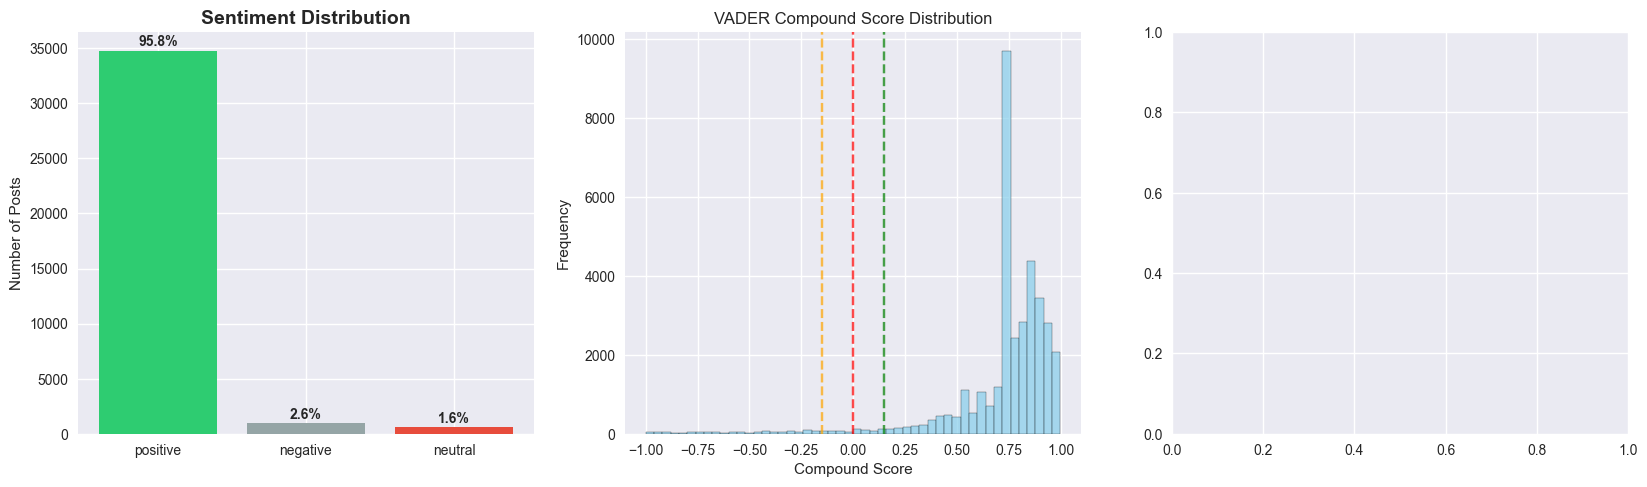

In [28]:
 #=====================================================================
# 7. COMPREHENSIVE VISUALIZATIONS
# =====================================================================

print(f"\n📊 PHASE 7: CREATING VISUALIZATIONS")
print("-"*50)

# Set up the plotting style
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 24))

# 1. Sentiment Distribution
ax1 = plt.subplot(4, 3, 1)
sentiment_counts = df_clean['sentiment_label'].value_counts()
colors = ['#2ecc71', '#95a5a6', '#e74c3c']  # green, gray, red
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Posts')

# Add percentages on bars
for bar, count in zip(bars, sentiment_counts.values):
    pct = count / len(df_clean) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + len(df_clean)*0.005, 
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Sentiment Score Distribution
ax2 = plt.subplot(4, 3, 2)
plt.hist(df_clean['vader_compound'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=optimal_threshold, color='green', linestyle='--', alpha=0.7)
plt.axvline(x=-optimal_threshold, color='orange', linestyle='--', alpha=0.7)
plt.title('VADER Compound Score Distribution')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

# 3. Text Length vs Sentiment
ax3 = plt.subplot(4, 3, 3)
sentiment_colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
for sentiment in sentiment_colors:
    data = df_clean[df_clean['sentiment_label'] == sentiment]['text_cleaned_length']
    plt.hist(data, alpha=0.6, label=sentiment, bins=30, color=sentiment_colors[sentiment])
plt.title('Text Length by Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, df_clean['text_cleaned_length'].quantile(0.95))

# 4. Hourly posting patterns (if timestamp available)
if timestamp_col and df_clean['parsed_datetime'].notna().sum() > 0:
    ax4 = plt.subplot(4, 3, 4)
    hourly_posts = df_clean['hour'].value_counts().sort_index()
    plt.bar(hourly_posts.index, hourly_posts.values, color='orange', alpha=0.7)
    plt.title('Posts by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Number of Posts')
    plt.xticks(range(0, 24, 2))
    
    # 5. Daily sentiment trends
    ax5 = plt.subplot(4, 3, 5)
    if len(daily_sentiment) > 1:
        plt.plot(daily_sentiment.index, daily_sentiment['positive_ratio'], 
                label='Positive', color='green', linewidth=2)
        plt.plot(daily_sentiment.index, daily_sentiment['negative_ratio'], 
                label='Negative', color='red', linewidth=2)
        plt.title('Daily Sentiment Trends')
        plt.xlabel('Date')
        plt.ylabel('Sentiment Ratio')
        plt.legend()
        plt.xticks(rotation=45)
    
    # 6. Day of week patterns
    ax6 = plt.subplot(4, 3, 6)
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_posts = df_clean['day_of_week'].value_counts().reindex(dow_order, fill_value=0)
    plt.bar(dow_posts.index, dow_posts.values, color='purple', alpha=0.7)
    plt.title('Posts by Day of Week')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
else:
    # Alternative visualizations if no timestamp
    ax4 = plt.subplot(4, 3, 4)
    plt.text(0.5, 0.5, 'No timestamp data\navailable', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    plt.title('Temporal Analysis')
    ax4.set_xticks([])
    ax4.set_yticks([])

# 7. Sentiment vs Subjectivity (TextBlob)
ax7 = plt.subplot(4, 3, 7)
scatter = plt.scatter(df_clean['textblob_polarity'], df_clean['textblob_subjectivity'], 
                     c=df_clean['vader_compound'], cmap='RdYlGn', alpha=0.6)
plt.colorbar(scatter, label='VADER Compound Score')
plt.title('Sentiment vs Subjectivity')
plt.xlabel('TextBlob Polarity')
plt.ylabel('TextBlob Subjectivity')

# 8. Top words visualization
ax8 = plt.subplot(4, 3, 8)
top_words_df = pd.DataFrame(top_words[:15], columns=['word', 'count'])
plt.barh(top_words_df['word'], top_words_df['count'], color='teal', alpha=0.7)
plt.title('Top 15 Most Frequent Words')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

# 9. Sentiment correlation matrix
ax9 = plt.subplot(4, 3, 9)
sentiment_cols = ['vader_compound', 'vader_pos', 'vader_neu', 'vader_neg', 
                  'textblob_polarity', 'textblob_subjectivity']
existing_cols = [col for col in sentiment_cols if col in df_clean.columns]
if len(existing_cols) > 1:
    corr_matrix = df_clean[existing_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=ax9, cbar_kws={'shrink': 0.8})
    plt.title('Sentiment Metrics Correlation')
else:
    plt.text(0.5, 0.5, 'Insufficient data\nfor correlation', ha='center', va='center', 
             transform=ax9.transAxes)

# 10. Box plot of sentiment scores by category
ax10 = plt.subplot(4, 3, 10)
sentiment_data = [df_clean[df_clean['sentiment_label'] == sentiment]['vader_compound'].values 
                  for sentiment in ['negative', 'neutral', 'positive']]
box_plot = plt.boxplot(sentiment_data, labels=['Negative', 'Neutral', 'Positive'], patch_artist=True)
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.title('Sentiment Score Distribution by Category')
plt.ylabel('VADER Compound Score')

# 11. Cumulative posts over time (if timestamp available)
ax11 = plt.subplot(4, 3, 11)
if timestamp_col and df_clean['parsed_datetime'].notna().sum() > 0:
    daily_posts = df_clean.groupby(df_clean['parsed_datetime'].dt.date).size()
    cumulative_posts = daily_posts.cumsum()
    plt.plot(cumulative_posts.index, cumulative_posts.values, color='blue', linewidth=2)
    plt.title('Cumulative Posts Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Posts')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No timestamp data\navailable', ha='center', va='center', 
             transform=ax11.transAxes, fontsize=12)

# 12. Sentiment by text length bins
ax12 = plt.subplot(4, 3, 12)
# Create text length bins
df_clean['length_bin'] = pd.cut(df_clean['text_cleaned_length'], 
                                bins=[0, 50, 100, 200, 500, float('inf')], 
                                labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

length_sentiment = df_clean.groupby(['length_bin', 'sentiment_label']).size().unstack(fill_value=0)
length_sentiment_pct = length_sentiment.div(length_sentiment.sum(axis=1), axis=0) * 100

if not length_sentiment_pct.empty:
    length_sentiment_pct.plot(kind='bar', stacked=True, ax=ax12, 
                              color=['#e74c3c', '#95a5a6', '#2ecc71'])
    plt.title('Sentiment Distribution by Text Length')
    plt.xlabel('Text Length Category')
    plt.ylabel('Percentage')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()